In [1]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

from utils.console.colored import ColoredText
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne.decoding import cross_val_multiscore
from mne import Epochs, create_info, events_from_annotations
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.time_frequency import AverageTFR

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Union
from utils.beep import Beeper
from sklearn.base import BaseEstimator
from abc import ABC, abstractmethod
from typing import Optional, Iterable, Generator, Callable
from mne import EpochsArray
from collections import UserDict, UserList
from combiners import EpochsCombiner
from mne.decoding import SlidingEstimator
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from utils.data_management import dict2str
import inspect
import scipy as sp

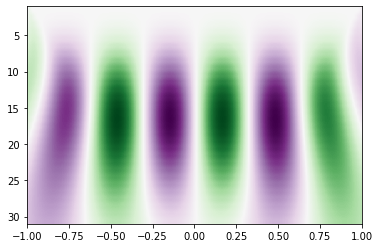

In [5]:
from scipy import signal

import matplotlib.pyplot as plt

t = np.linspace(-1, 1, 200, endpoint=False)

# sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
sig = np.sin( 10 * t)

widths = np.arange(1, 31)

cwtmatr = signal.cwt(sig, signal.ricker, widths)

plt.imshow(cwtmatr, extent=[-1, 1, 31, 1], cmap='PRGn', aspect='auto',

           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

plt.show()

In [ ]:
from cross_runs_TF_planes import CrossRunsTFScorer
import pickle
from utils.storage_management import check_path

root = '../'
subjects_dir = os.path.join(root, 'Source/Subjects')
pics_dir = os.path.join(root, 'Source/Pictures')
check_path(pics_dir)
for subject_name in os.listdir(subjects_dir):
    tf_planes_path = os.path.join(subjects_dir, subject_name, 'TF_planes')
    for session in os.listdir(tf_planes_path):
        session_path = os.path.join(tf_planes_path, session)
        for lock in os.listdir(session_path):
            lock_path = os.path.join(session_path, lock)
            for cross_runs_TF_scorer_file in os.listdir(lock_path):
                cross_runs_TF_scorer = pickle.load(
                    open(
                        os.path.join(lock_path, cross_runs_TF_scorer_file), 'rb')
                )
                print(subject_name, session, lock, cross_runs_TF_scorer_file[:-4])
                tmin, tmax = -.500, .500
                n_cycles = 14
                min_freq = 5.
                max_freq = 70.
                n_freqs = 7
                freqs_range = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
                window_spacing = (n_cycles / np.max(freqs_range) / 2.)
                centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
                n_windows = len(centered_w_times)
                av_tfr = AverageTFR(create_info(['freq'], 1000), cross_runs_TF_scorer.mean()[np.newaxis, :],
                                centered_w_times, freqs_range[1:], 1)
                chance = .5
                fig = av_tfr.plot(
                    [0],
                    vmin=chance,
                    title=f"{subject_name}, {session}, {lock}, {cross_runs_TF_scorer_file[:-4]}",
                    cmap=plt.cm.Reds
                )
                plt.show()

                # plt.savefig(
                #     os.path.join(
                #         pics_dir, f'{subject_name}_{session}_{lock}_{cross_runs_TF_scorer_file[:-4]}.png'
                #     ),
                # )





In [43]:
min_freq = 5.
max_freq = 70.
tmin, tmax = -.500, .500
n_cycles = 14.
n_freqs = 7
freqs = np.logspace(np.log10(min_freq), np.log10(max_freq), n_freqs)
print(freqs)
window_spacing = (n_cycles / max_freq / 2.)
print(window_spacing)
centered_w_times = np.arange(tmin, tmax, window_spacing)[1:]
print(np.round(centered_w_times,2))

[ 5.          7.76231645 12.05071132 18.70828693 29.04392867 45.08963303
 70.        ]
0.1
[-0.4 -0.3 -0.2 -0.1 -0.   0.1  0.2  0.3  0.4]


In [44]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
print(freqs)

[ 6.          7.71912254  9.93080879 12.77618833 16.43682721 21.1463139
 27.2051647  35.        ]


In [8]:
# speakers
sad_beep = Beeper(duration=[.1, .15, .25], frequency=[280, 240, 190], repeat=3)
happy_beep = Beeper(duration=[.1, .1, .15, .25], frequency=[400, 370, 470, 500], repeat=4)

# paths
content_root = '../'
subjects_folder_path = os.path.join(content_root, 'Source/Subjects')
subject_path = os.path.join(subjects_folder_path, 'Az_Mar_05')
raw_file_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
raw_path = os.path.join(subject_path, 'Raw', 'ML_Subject05_P1_tsss_mc_trans.fif')
resp_lock_lm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LM_B1_epochs.fif')
resp_lock_rm_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RM_B1_epochs.fif')
resp_lock_li_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_LI_B1_epochs.fif')
resp_lock_ri_B1_epochs_path = os.path.join(subject_path, 'Epochs', 'RespCor_RI_B1_epochs.fif')

# readers
original_data = mne.io.read_raw_fif(raw_file_path)
original_info = original_data.info
resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)
resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)
resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


print(resp_lock_lm_B1_epochs.info)
print(original_info)
print(original_info == resp_lock_lm_B1_epochs.info)

Opening raw data file ../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif...
    Range : 25000 ... 1114999 =     25.000 ...  1114.999 secs
Ready.
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available


/tmp/ipykernel_883241/2758464156.py:17: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Raw/ML_Subject05_P1_tsss_mc_trans.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  original_data = mne.io.read_raw_fif(raw_file_path)
/tmp/ipykernel_883241/2758464156.py:19: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_lm_B1_epochs = mne.read_epochs(resp_lock_lm_B1_epochs_path)


Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
27 matching events found


/tmp/ipykernel_883241/2758464156.py:20: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RM_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_rm_B1_epochs = mne.read_epochs(resp_lock_rm_B1_epochs_path)
/tmp/ipykernel_883241/2758464156.py:21: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_LI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_li_B1_epochs = mne.read_epochs(resp_lock_li_B1_epochs_path)


No baseline correction applied
0 projection items activated
Reading ../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
<Info | 23 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0122, MEG0123, MEG0132, MEG0133, MEG0143, ...
 chs: 204 GRAD
 custom_ref_applied: False
 description: Vectorview system
 dev_head_t: MEG device -> head transform
 dig: 138 items (3 Cardinal, 4 HPI, 131 Extra)
 events: 1 item (list)
 experimenter: meg
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 330.0 Hz
 meas_date: 2018-11-23 11:23:40 UTC
 meas_id: 4 items (dic

/tmp/ipykernel_883241/2758464156.py:22: RuntimeWarning: This filename (../Source/Subjects/Az_Mar_05/Epochs/RespCor_RI_B1_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  resp_lock_ri_B1_epochs = mne.read_epochs(resp_lock_ri_B1_epochs_path)


In [ ]:
# combiner

#classes
first_class_indices = (0, 1)
second_class_indices = (2, 3)

In [4]:
combiner = EpochsCombiner(
    resp_lock_lm_B1_epochs,
    resp_lock_li_B1_epochs,
    resp_lock_rm_B1_epochs,
    resp_lock_ri_B1_epochs
).filter(l_freq=5., h_freq=10.)\
    .crop(tmin=-.3, tmax=.5)\
    .combine((0, 1), (2, 3))


csp = CSP(
    n_components=2,
    reg='shrinkage',
    rank='info',
    component_order='mutual_info'
)

print(combiner.X.shape)

X = csp.fit_transform(combiner.X, combiner.Y)
Y = combiner.Y

print(X.shape)

first_class = X[Y==0]
second_class = X[Y==1]

Setting up band-pass filter from 5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1651 samples (1.651 sec)



/home/user/PycharmProjects/FingerMovementDecoder/combiners.py:94: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_array.copy().filter(l_freq, h_freq, *args, **kwargs)


Setting up band-pass filter from 5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1651 samples (1.651 sec)



/home/user/PycharmProjects/FingerMovementDecoder/combiners.py:94: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_array.copy().filter(l_freq, h_freq, *args, **kwargs)


Setting up band-pass filter from 5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1651 samples (1.651 sec)



/home/user/PycharmProjects/FingerMovementDecoder/combiners.py:94: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_array.copy().filter(l_freq, h_freq, *args, **kwargs)


Setting up band-pass filter from 5 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1651 samples (1.651 sec)



/home/user/PycharmProjects/FingerMovementDecoder/combiners.py:94: RuntimeWarning: filter_length (1651) is longer than the signal (1001), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_array.copy().filter(l_freq, h_freq, *args, **kwargs)


(117, 204, 801)
Computing rank from data with rank='info'
    MAG: rank 204 after 0 projectors applied to 204 channels
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank='info'
    MAG: rank 204 after 0 projectors applied to 204 channels
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
(117, 2)


In [6]:
print(X)

[[-1.87536999 -0.25172635]
 [-2.42206443 -0.66806063]
 [-2.79366434 -0.66089572]
 [-1.5132872  -0.56556849]
 [-1.93594372 -0.58480369]
 [-2.89998873 -0.86139834]
 [-2.15195    -0.66647477]
 [-1.54590834 -0.24675523]
 [-2.15733524  0.24991067]
 [-1.37963087 -0.39009158]
 [-2.93319158 -0.7150366 ]
 [-2.42904428  0.07671245]
 [-2.59525359 -1.05295692]
 [-3.27245029 -0.8192468 ]
 [-1.69902579 -0.65049536]
 [-1.94972388 -0.48490361]
 [-1.83804695 -0.02777883]
 [-2.20387389  0.26809572]
 [-2.40946897 -0.26153114]
 [-2.2134381   0.31126635]
 [-2.3584007  -0.37002003]
 [-1.80988155  0.3274803 ]
 [-1.35162995 -0.06795508]
 [-1.43151073  0.0407014 ]
 [-2.08449039  0.1079191 ]
 [-1.78211956  0.3530267 ]
 [-1.40485535  0.36881339]
 [-1.3269193  -0.61065245]
 [-2.01937343 -0.23596045]
 [-2.24170176 -0.93225942]
 [-2.50573769 -0.26471156]
 [-0.96794889 -1.11100017]
 [-1.93098249 -0.13146124]
 [-2.07673334 -0.46779179]
 [-2.27429885 -0.45019825]
 [-1.81081174 -0.33674622]
 [-1.89524744 -0.40043875]
 

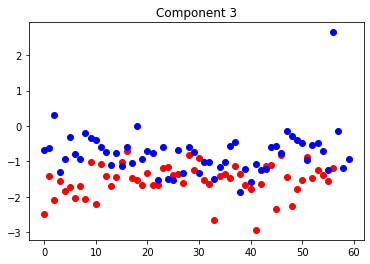

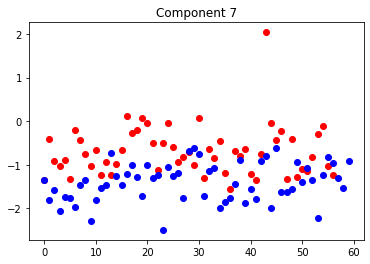

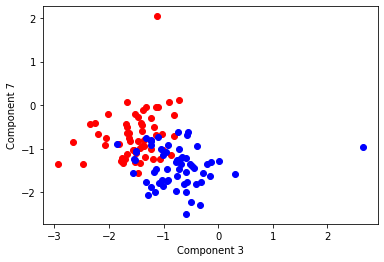

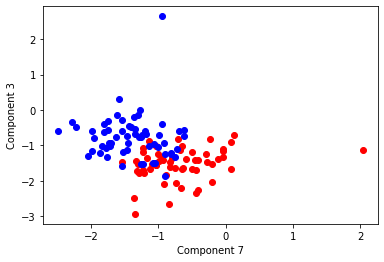

In [4]:
plt.plot(first_class[:, 2], 'or', second_class[:, 2], 'ob')
plt.title(f'Component {3}')
plt.show()

plt.plot(first_class[:, 6], 'or', second_class[:, 6], 'ob')
plt.title(f'Component {7}')
plt.show()

plt.plot(first_class[:, 2], first_class[:, 6], 'or', second_class[:, 2], second_class[:, 6], 'ob')
plt.xlabel(f'Component {3}')
plt.ylabel(f'Component {7}')
plt.show()

plt.plot(first_class[:, 6], first_class[:, 2], 'or', second_class[:, 6], second_class[:, 2], 'ob')
plt.xlabel(f'Component {7}')
plt.ylabel(f'Component {3}')
plt.show()

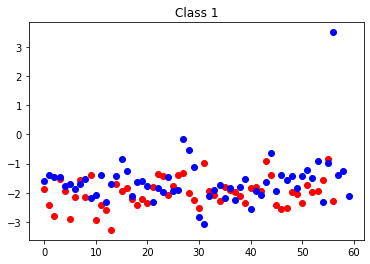

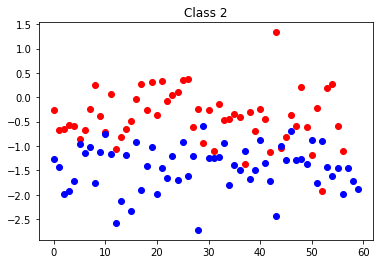

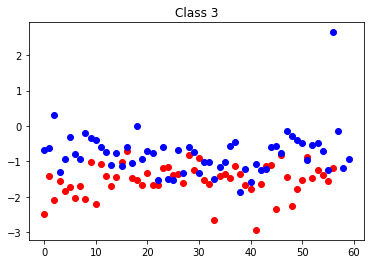

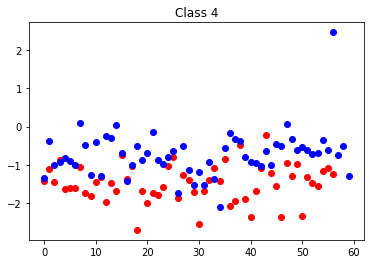

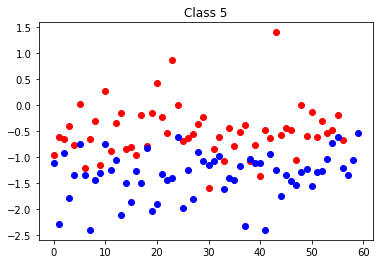

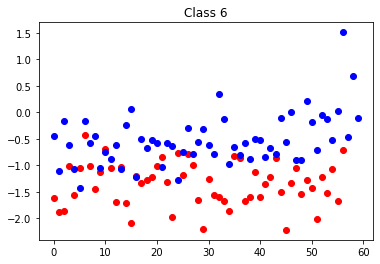

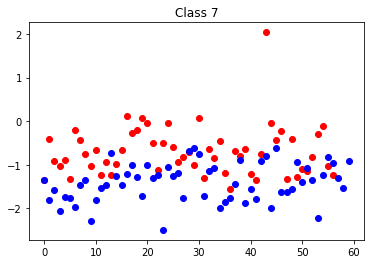

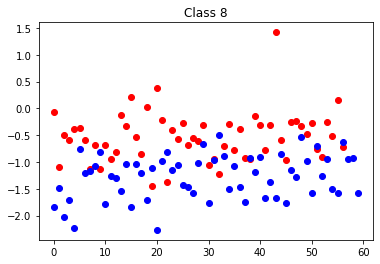

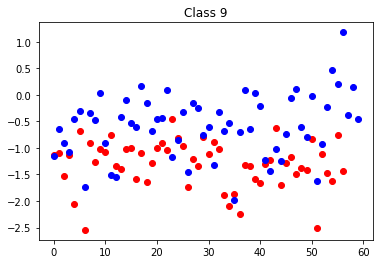

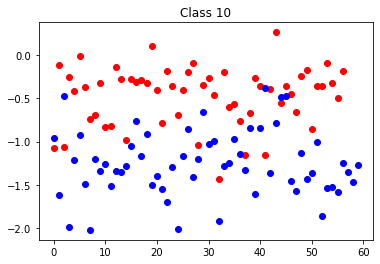

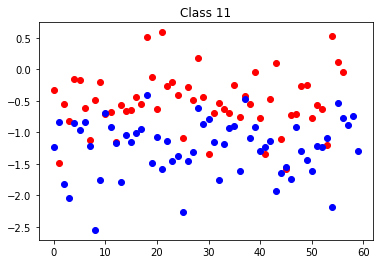

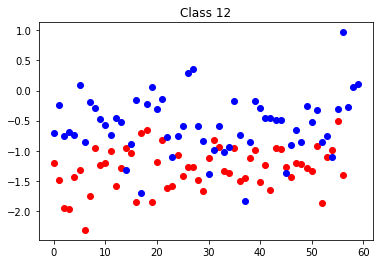

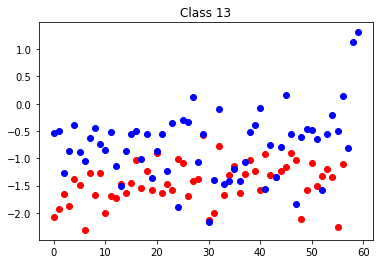

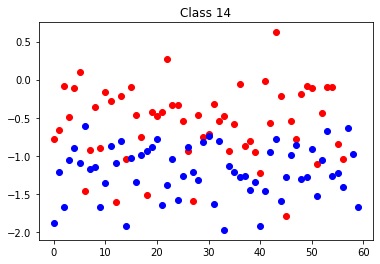

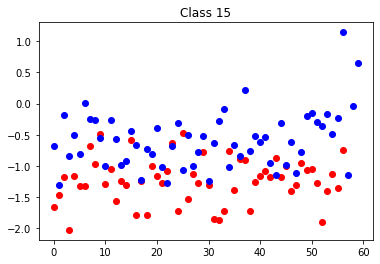

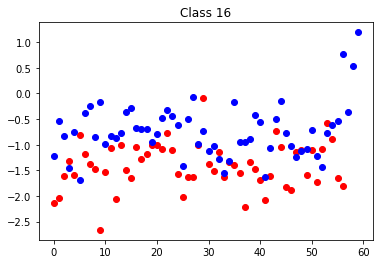

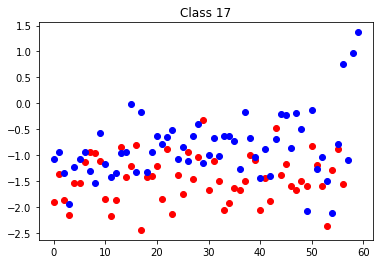

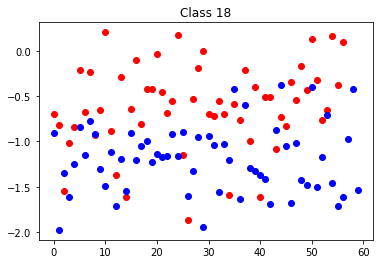

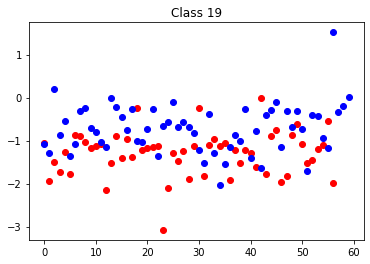

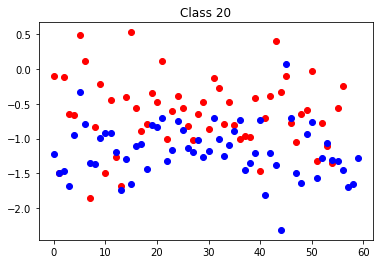

In [5]:
for i in range(first_class.shape[1]):
    plt.plot(first_class[:, i], 'or', second_class[:, i], 'ob')
    plt.title(f'Class {i+1}')
    plt.show()



In [ ]:
p = np.random.permutation(Y.shape[0])
Y = Y[p]
X = X[p, :]
print(X.shape)
scores = dict()
clf = LogisticRegression()
for component in X.T:
    score = clf.fit(component.reshape(component.shape[0], -1), Y).score(component.reshape(component.shape[0], -1), Y)
    scores.update({score: component})

scores = dict(
    sorted(
        scores.items(),
        key=lambda item: item[0],
        reverse=True
    )
)
X = np.array(list(scores.values())[:5]).T
print(X.shape)


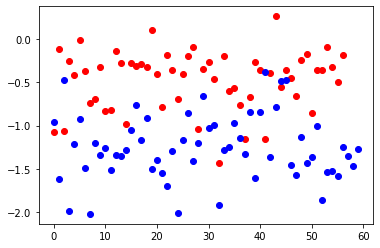

In [7]:
i = 9
plt.plot(first_class[:, i], 'or', second_class[:, i], 'ob')
plt.show()

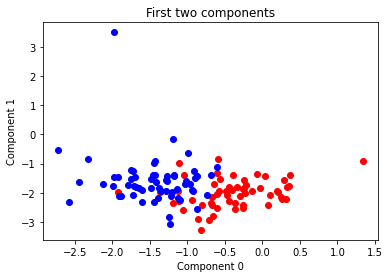

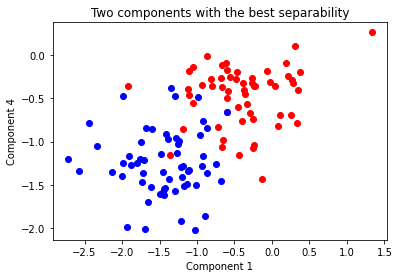

In [8]:
i = 1
j = 0
plt.plot(first_class[:, i], first_class[:, j], 'or', second_class[:, i], second_class[:, j], 'ob')
plt.title('First two components')
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.show()
i = 1
j = 9
plt.plot(first_class[:, i], first_class[:, j], 'or', second_class[:, i], second_class[:, j], 'ob')
plt.title('Two components with the best separability')
plt.xlabel('Component 1')
plt.ylabel('Component 4')
plt.show()

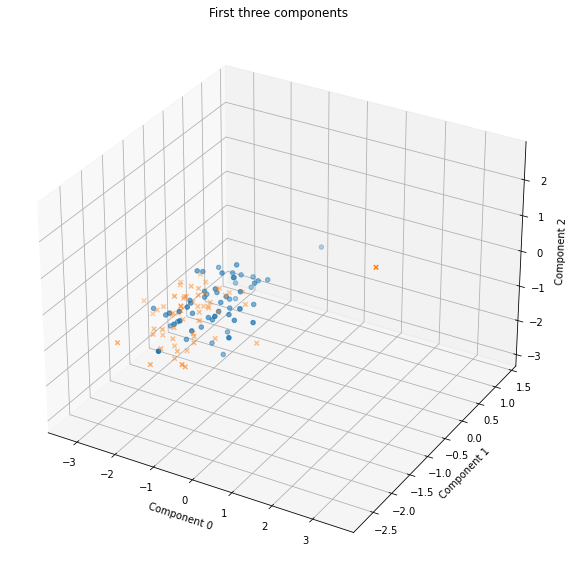

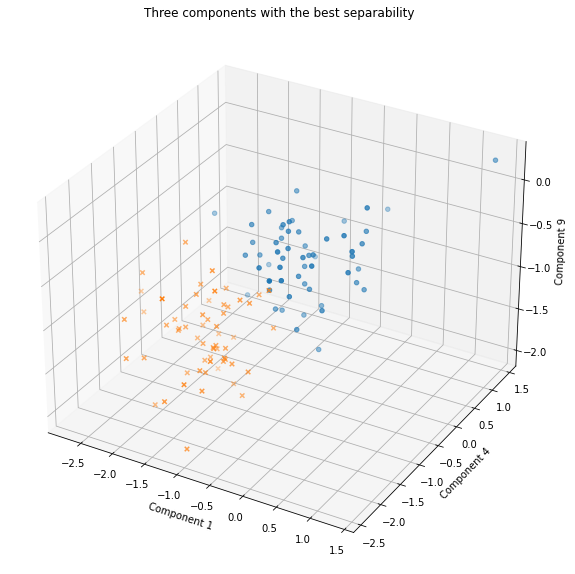

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for m, cm, cls in [('o', 'Reds', first_class), ('x', 'Reds', second_class)]:
    x = cls[:, 0]
    y = cls[:, 1]
    z = cls[:, 2]
    ax.scatter(x, y, z, marker=m, cmap=cm, )

ax.set_xlabel('Component 0')
ax.set_ylabel('Component 1')
ax.set_zlabel('Component 2')
plt.title('First three components')
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
for m, cm, cls in [('o', 'Reds', first_class), ('x', 'Reds', second_class)]:
    x = cls[:, 1]
    y = cls[:, 4]
    z = cls[:, 9]
    ax.scatter(x, y, z, marker=m, cmap=cm, )

plt.title('Three components with the best separability')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 4')
ax.set_zlabel('Component 9')

plt.show()

Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.


/home/user/PycharmProjects/FingerMovementDecoder/utils/machine_learning/plotting.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(true_mesh), np.array(false_mesh)


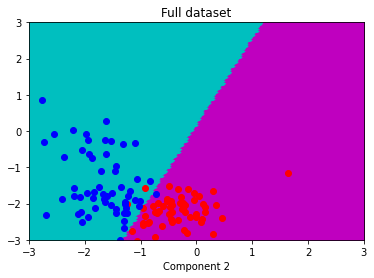

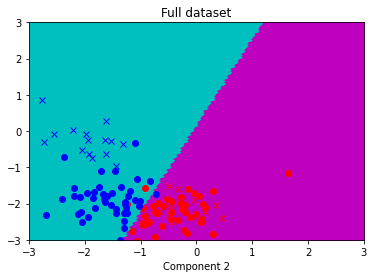

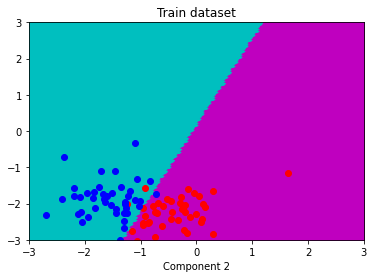

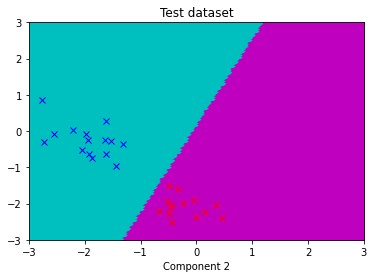

In [10]:
from utils.machine_learning.plotting import binary_dicision_boundary
from sklearn.neural_network import MLPClassifier

csp = CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
            component_order='alternate'
        )


clf = LogisticRegression()

# Penalized model
# clf = MLPClassifier(
#             (100, 50, 10),
#             max_iter=500,
#             early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='constant',
#             learning_rate_init = 0.05,
#             alpha=.05,
#             momentum=.99
#         )

# Optimized model
# clf = MLPClassifier(
#             (100, 50, 10),
#             max_iter=1000,
#             # early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='invscaling',
#             # learning_rate_init = 0.05,
#             # alpha=.005,
#             # momentum=.99
#         )

X = combiner.X
Y = combiner.Y

x_train, x_test, y_train, y_test = train_test_split(X, Y, shuffle=True)


x_train_csp = csp.fit_transform(x_train, y_train)
x_test_csp = csp.fit_transform(x_test, y_test)


clf.fit(x_train_csp, y_train)
true_mesh, false_mesh = binary_dicision_boundary(clf, np.linspace(-3, 3, 100))

x_train_csp_class1 = x_train_csp[y_train == 0]
x_train_csp_class2 = x_train_csp[y_train == 1]
x_test_csp_class1 = x_test_csp[y_test == 0]
x_test_csp_class2 = x_test_csp[y_test == 1]

# full dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'or',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'ob'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# full dataset with train/test

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# train dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )


plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.title('Train dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# test dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Test dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank='full'
    MAG: rank 204 from info
Reducing data rank from 204 -> 204
Estimating covariance using SHRINKAGE
Done.


/home/user/PycharmProjects/FingerMovementDecoder/utils/machine_learning/plotting.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(true_mesh), np.array(false_mesh)


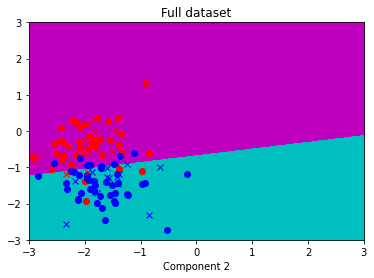

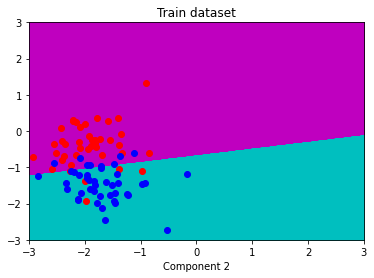

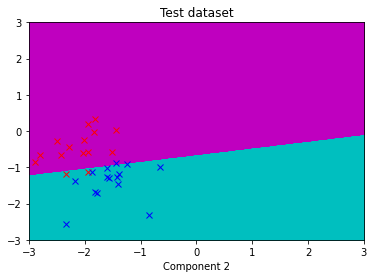

In [7]:
csp = CSP(
            n_components=2,
            reg='shrinkage',
            rank='full',
            # component_order='alternate'
        )

clf = LogisticRegression()

# Penalized model
# clf = MLPClassifier(
#             (100, 50, 10),
#             max_iter=500,
#             early_stopping=True,
#             activation='relu',
#             solver='adam',
#             learning_rate='constant',
#             learning_rate_init = 0.05,
#             alpha=.005,
#             momentum=.99
#         )

# Optimized model
# clf = MLPClassifier(
#             (100, 50, 10),
#             max_iter=1000,
#             # early_stopping=True,
#             # activation='relu',
#             solver='adam',
#             learning_rate='invscaling',
#             # learning_rate_init = 0.05,
#             # alpha=.005,
#             # momentum=.99
#         )

Y = combiner.Y
X = combiner.X
p = np.random.permutation(Y.shape[0])
Y = Y[p]
X = X[p, :, :]
X = csp.fit_transform(X, Y)

x_train_csp, x_test_csp, y_train, y_test = train_test_split(X, Y, shuffle=True)

clf.fit(x_train_csp, y_train)
true_mesh, false_mesh = binary_dicision_boundary(clf, np.linspace(-3, 3, 1000))

x_train_csp_class1 = x_train_csp[y_train == 0]
x_train_csp_class2 = x_train_csp[y_train == 1]
x_test_csp_class1 = x_test_csp[y_test == 0]
x_test_csp_class2 = x_test_csp[y_test == 1]

# full dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Full dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()


# train dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
    x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
)
plt.title('Train dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# test dataset

for true, false in zip(true_mesh, false_mesh):
    plt.plot(
        true[:, 0],
        true[:, 1],
        'om',
        false[:, 0],
        false[:, 1],
        'oc'
    )

plt.plot(
    x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
    x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
)
plt.title('Test dataset')
plt.xlabel('Component 1')
plt.xlabel('Component 2')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

In [151]:
# x_train_csp_class1 = x_train_csp[y_train == 0]
# x_train_csp_class2 = x_train_csp[y_train == 1]
# x_test_csp_class1 = x_test_csp[y_test == 0]
# x_test_csp_class2 = x_test_csp[y_test == 1]
# plt.plot(
#     x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
#     x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
# )
# plt.plot(
#     x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
#     x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
# )
# plt.title('Full dataset')
# plt.xlabel('Component 1')
# plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
# plt.show()
#
# plt.plot(
#     x_train_csp_class1[:, 0], x_train_csp_class1[:, 1], 'or',
#     x_train_csp_class2[:, 0], x_train_csp_class2[:, 1], 'ob'
# )
# plt.title('Train dataset')
# plt.xlabel('Component 1')
# plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
# plt.show()
#
# plt.plot(
#     x_test_csp_class1[:, 0], x_test_csp_class1[:, 1], 'xr',
#     x_test_csp_class2[:, 0], x_test_csp_class2[:, 1], 'xb'
# )
# plt.title('Test dataset')
# plt.xlabel('Component 1')
# plt.xlabel('Component 2')
# plt.xlim(-3, 3)
# plt.ylim(-3, 3)
# plt.show()

